In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/mpf/Sites/OPT-blog/posts/dictionary-learning"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
import Pkg
Pkg.activate(".")
using HDF5, LinearAlgebra, Plots, Flux, Lazy, Distributions, Statistics
import Random: seed!

  Activating project at `~/Sites/OPT-blog/posts/dictionary-learning`


In [3]:
function atomicdescent(ball, M, b; depth=10)
	x = zeros(length(M'b))
	r = copy(b);        f = [0.5*norm(r)^2]
	for k = 1:depth
		a = ball'(M'r)             # <--- many aligning choices! See below.
		Ma = M*a
		α = dot(Ma, r)/dot(Ma, Ma) # <--- exact linearch optional.
		α < 0 && break
		x = x + α*a
		r = r - α*Ma;   f = [f; 0.5*norm(r)^2]
	end
	return 0.5*norm(r)^2, x, f
end;

In [4]:
infball(z) = maximum(abs, z)
twoball(z) = norm(z)
sclball(z, M) = twoball(z./diag(M'M));

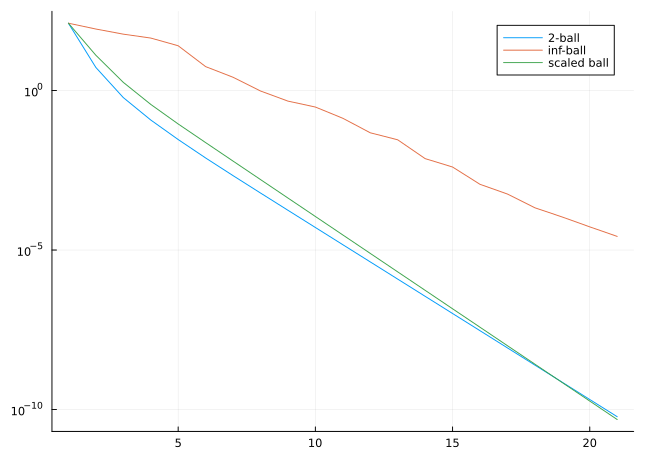

In [5]:
seed!(1234)
(m, n, p) = 50, 6, 0.8
x = rand(Bernoulli(p), n)
M = randn(m,n)
b = M*x

@> begin # lazy threading is awesome!
	map([twoball, infball, z->sclball(z,M)]) do ball
		atomicdescent(ball, M, b, depth=20)[3]
	end
	plot(yaxis=:log, lab=["2-ball" "inf-ball" "scaled ball"])
end

In [6]:
struct Subspace
	Q
end
function Subspace(m, k)
	A = randn(m, k)
	return Subspace(qr(A).Q[:,1:k])
end
function (s::Subspace)()
	n = size(s.Q, 2)
	v = (v=randn(n)) / norm(v)
	return s.Q*v		
end

In [7]:
loss(M, b) = 0.5*norm(b - M*(M\b))^2
loss(M; trials=100) = mean(b->loss(M, b), take(trials, repeatedly(sampler)))
atomicloss(M, b) = atomicdescent(infball, M, b, depth=2)[1]

atomicloss (generic function with 1 method)

In [8]:
(m, k) = 50, 2
sampler = Subspace(m, k)
M = randn(m, k);

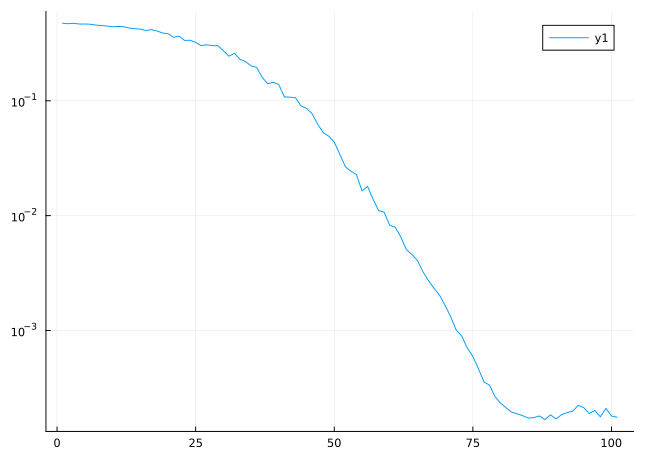

In [9]:
history = [loss(M)]
Mtrain = copy(M)
opt = Momentum(1)
for b in take(100, repeatedly(sampler))
	g = gradient(M->atomicloss(M, b), Mtrain)[1]
	Flux.update!(opt, Mtrain, g)
	push!(history, loss(Mtrain))
end
plot(history, yaxis=:log)

In [10]:
#| echo: true
#| output: asis
swimmers = h5open("Swimmer.h5","r") do dataset
		     s = convert(Array{Float32,3}, read(dataset)["Y"])
           	 # shift the configuration index to the end (needed for Flux)
	         s = permutedims(s, (2,3,1))
	         # normalize each image
	         s /= 255
	         maxper = maximum(reshape(s, prod(size(s)[1:2]),:))
	         return broadcast(/, s, maxper)
end
println("The set contains $(size(swimmers)[3]) swimmer configurations, each of size $(size(swimmers)[1:2]).")

The set contains 256 swimmer configurations, each of size (32, 32).


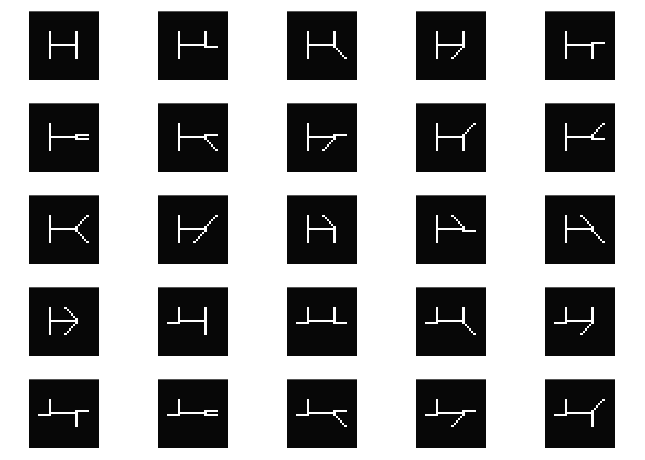

In [11]:
plt = [plot(Gray.(swimmers[:,:,i])) for i in 1:25]
plot(plt..., axis=([],false),layout=(5,5))

In [12]:
function procrustes(A, B)
	U, s, V = svd(B*A')
	return U*V'
end;